In [1]:
print("hello")

hello


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
train_token_level_probe.py

変更点:
  - Sequence-Level (文章全体で1つの点数) ではなく、
  - Token-Level (各トークンごとに点数) を出力するように変更。
  - これにより、PPOで「創造的な部分」だけを局所的に褒めることが可能になる。
"""

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.nn.utils.rnn import pad_sequence

# ==========================================
# 1. 設定 & 定数
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
SAVE_PATH = "transformer_creativity_probe_token_level.pt" # ファイル名変更
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_LAYER = 24
Input_Dim = 3584

def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# ==========================================
# 2. モデル定義 (Token-Level Probe)
# ==========================================
class TransformerProbe(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=4):
        super().__init__()
        self.project = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.head = nn.Linear(d_model, 1)
        
    def forward(self, x, src_key_padding_mask=None):
        # x: [Batch, Seq, Input_Dim]
        x = self.project(x)
        
        # Transformerに入力 (maskがあればパディング部分のAttentionを切る)
        if src_key_padding_mask is not None:
             # nn.TransformerEncoderLayerは mask=True の場所を無視する仕様
             # (実装によっては逆の場合もあるがPyTorch公式は True=Ignore)
             x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        else:
             x = self.transformer(x)
        
        # ★変更点: 平均化(mean)を削除！
        # Global Average Poolingを廃止し、シーケンスのまま出力する
        # output: [Batch, Seq, 1]
        return self.head(x)


# ==========================================
# 3. データセット生成 (Enhanced)
# ==========================================
def generate_enhanced_dataset(model, tokenizer, n_samples=3000):
    model.eval()
    print(f"Generating {n_samples} samples for Token-Level Training...")

    prompts_pos = [
        "Write a short poem using only simple words:",
        "Describe a complex emotion using a metaphor:",
        "Compose a mysterious story opening:",
        "Propose a groundbreaking research idea combining quantum physics and LLMs:",
        "Suggest a novel method to train AI without using any human data:",
        "Invent a new neural network architecture inspired by biological ecosystems:",
        "Write an abstract for a paper that challenges the scaling laws of transformers:",
    ]

    prompts_boring = [
        "State a dry fact about history:",
        "Explain a basic grammatical rule:",
        "Describe the process of boiling water:",
    ]
    prompts_instruction = [
        "Give a polite response declining a request:",
        "Say 'Here is the summary' in a formal way:",
        "Write a standard AI assistant response:",
    ]
    prompts_cliche_research = [
        "Describe a standard MNIST digit classification experiment:",
        "Explain how to fine-tune BERT for sentiment analysis:",
        "Write a generic introduction about the importance of big data:",
        "State the definition of supervised learning from a textbook:",
    ]
    
    jargon_prefixes = ["Hyper-", "Quantum", "Neuro-", "Multi-", "Meta-", "Cyber-", "Deep"]
    jargon_nouns = ["Entropy", "Optimization", "Tensors", "Gradients", "Blockchain", "Synergy", "Paradigm"]
    jargon_verbs = ["disrupts", "leverages", "synthesizes", "encrypts", "validates"]

    data = []
    labels = []

    # Positive (40%)
    for _ in tqdm(range(int(n_samples * 0.4)), desc="Positive"):
        prompt = random.choice(prompts_pos)
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=64, temperature=0.95, do_sample=True, pad_token_id=tokenizer.eos_token_id)
        text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
        data.append(text)
        labels.append(1.0)

    # Negative (60%)
    for _ in tqdm(range(int(n_samples * 0.6)), desc="Negative"):
        r = random.random()
        
        if r < 0.25: # Boring
            prompt = random.choice(prompts_boring)
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=64, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
            text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
            
        elif r < 0.50: # Instruction
            prompt = random.choice(prompts_instruction)
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=64, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
            text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()

        elif r < 0.75: # Cliché Research
            prompt = random.choice(prompts_cliche_research)
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=64, temperature=0.1, do_sample=True, pad_token_id=tokenizer.eos_token_id)
            text = tokenizer.decode(out[0], skip_special_tokens=True).replace(prompt, "").strip()
            
        else: # Fake Jargon
            p1 = random.choice(jargon_prefixes) + random.choice(jargon_nouns)
            p2 = random.choice(jargon_prefixes) + random.choice(jargon_nouns)
            v = random.choice(jargon_verbs)
            text = f"The {p1} {v} the {p2} for optimal performance within the stochastic framework."
            
        data.append(text)
        labels.append(0.0)

    return data, labels


# ==========================================
# 4. 特徴量抽出ヘルパー
# ==========================================
def extract_features(model, tokenizer, texts, batch_size=16):
    model.eval()
    features = []
    
    print("Extracting Hidden States...")
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i : i+batch_size]
        batch_texts = [t if t.strip() else "empty" for t in batch_texts]
        
        # padding=Trueで長さを揃える
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        
        h = outputs.hidden_states[TARGET_LAYER].float().cpu() # [Batch, Seq, Dim]
        
        # バッチ内の各シーケンスを取り出し、パディング（attention_mask=0）を除去して保存
        # こうすることで、後で正しい長さで扱える
        mask = inputs.attention_mask.cpu()
        
        for j in range(len(batch_texts)):
            valid_len = mask[j].sum().item()
            # パディングされていない有効な部分だけを取り出す
            seq_feature = h[j, :valid_len, :] 
            features.append(seq_feature)
            
    return features


# ==========================================
# 5. Token-Level対応のカスタムCollator
# ==========================================
# データローダーがバッチを作る時に、可変長の系列をパディングしつつ、
# ラベルも同じ長さに引き伸ばす処理を行う
class TokenLevelCollator:
    def __call__(self, batch):
        # batch: list of (feature_tensor, label_float)
        features = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        
        # 1. Featureをパディング [Batch, MaxSeq, Dim]
        X = pad_sequence(features, batch_first=True, padding_value=0.0)
        
        # 2. LabelをSequenceに合わせて拡張 [Batch, MaxSeq, 1]
        # パディング部分を無視するためのマスクも作る
        batch_size = len(features)
        max_len = X.size(1)
        
        Y = torch.zeros(batch_size, max_len, 1)
        Mask = torch.zeros(batch_size, max_len) # 1=Valid, 0=Padding (Loss計算用)
        PaddingMask = torch.ones(batch_size, max_len).bool() # True=Padding (Transformer入力用)
        
        for i, (feat, lbl) in enumerate(zip(features, labels)):
            length = feat.size(0)
            # 有効な長さにラベルを埋める
            Y[i, :length, 0] = lbl 
            # Loss用のマスク (1.0 = 計算する)
            Mask[i, :length] = 1.0
            # Transformer用のマスク (False = 計算する)
            PaddingMask[i, :length] = False
            
        return X, Y, Mask, PaddingMask

# ==========================================
# 6. 厳密評価ベンチマーク (Token-Level版)
# ==========================================
def strict_benchmark(probe, base_model, tokenizer):
    print("\n=== 🛑 Running Strict Research Benchmark (Token-Level) ===")
    
    cases = [
        ("Research", "Cliché", "Using deep learning to classify images of cats and dogs using CNNs."),
        ("Research", "Novel", "Training LLMs using simulated debates between historical figures to improve reasoning."),
        ("Research", "Nonsense", "Fine-tuning a neural network on the taste of the color blue using quantum gradients."),
        ("Story", "Novel", "A murder mystery where the detective is the ghost of the victim."),
    ]
    
    results = []
    probe.eval()
    
    print(f"{'Type':10s} | {'Avg Score':8s} | Text")
    print("-" * 60)
    
    for domain, type_, text in cases:
        inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = base_model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER] # [1, Seq, Dim]
            
            # Probe Inference
            # Token-Levelなので [1, Seq, 1] が返ってくる
            logits = probe(h.to(DEVICE).float()) 
            
            # 平均スコアを取って比較する
            avg_score = logits.mean().item()
            
        results.append({"Domain": domain, "Type": type_, "Score": avg_score})
        print(f"{type_:10s} | {avg_score:8.4f} | {text[:40]}...")
        
    return pd.DataFrame(results)

In [3]:
print(f"Loading Base Model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map="auto"
)

# --- B. データ作成 & 特徴抽出 ---
texts, labels = generate_enhanced_dataset(base_model, tokenizer, n_samples=3000)
features_list = extract_features(base_model, tokenizer, texts)

# Dataset作成 (まだパディングしない)
# features_list は [Seq, Dim] のテンソルのリスト
raw_data = list(zip(features_list, labels))

# Train/Test Split (リストのまま分割)
train_data, test_data = train_test_split(raw_data, test_size=0.15, random_state=42)

# DataLoader (ここでCollatorを使ってバッチ化＆パディング)
collator = TokenLevelCollator()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collator)

# --- C. 学習 (Training) ---
print("\nStarting Token-Level Probe Training...")
probe = TransformerProbe(Input_Dim).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss(reduction='none') # マスク処理のため reduction='none'

for epoch in range(15):
    probe.train()
    total_loss = 0
    total_tokens = 0
    
    for batch_X, batch_Y, mask_loss, mask_pad in train_loader:
        batch_X = batch_X.to(DEVICE)     # [B, S, D]
        batch_Y = batch_Y.to(DEVICE)     # [B, S, 1]
        mask_loss = mask_loss.to(DEVICE) # [B, S]
        mask_pad = mask_pad.to(DEVICE)   # [B, S] (Bool)
        
        optimizer.zero_grad()
        
        # Forward (padding maskを渡して、無効なトークンのAttentionを切る)
        outputs = probe(batch_X, src_key_padding_mask=mask_pad) # [B, S, 1]
        
        # Loss計算
        loss_raw = criterion(outputs, batch_Y) # [B, S, 1]
        loss_raw = loss_raw.squeeze(-1)        # [B, S]
        
        # パディング部分のLossを0にする
        loss_masked = loss_raw * mask_loss
        
        # 有効なトークン数で割って平均化
        loss = loss_masked.sum() / mask_loss.sum()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Avg Loss = {total_loss/len(train_loader):.4f}")

# --- D. 厳密評価 ---
df_res = strict_benchmark(probe, base_model, tokenizer)

# 判定
research_res = df_res[df_res["Domain"] == "Research"]
novel_score = research_res[research_res["Type"] == "Novel"]["Score"].values[0]
cliche_score = research_res[research_res["Type"] == "Cliché"]["Score"].values[0]
nonsense_score = research_res[research_res["Type"] == "Nonsense"]["Score"].values[0]

print("\n=== 📝 Final Verdict ===")
print(f"Research Novel:    {novel_score:.2f}")
print(f"Research Cliché:   {cliche_score:.2f}")
print(f"Research Nonsense: {nonsense_score:.2f}")

success = False
if novel_score > cliche_score and novel_score > nonsense_score:
    print("✅ PASS: Novel ideas are rated highest!")
    success = True
elif novel_score > cliche_score:
    print("⚠️ CONDITIONAL PASS: Novel > Cliché.")
    success = True
else:
    print("❌ FAIL: Probe prefers Cliché or Nonsense.")

# --- E. 保存 ---
if success:
    checkpoint = {
        "model_state_dict": probe.state_dict(),
        "config": {
            "input_dim": Input_Dim,
            "d_model": 256,
            "nhead": 4,
            "layer_idx": TARGET_LAYER,
            "description": "Token-Level Research-Aware Probe",
            "token_level": True # フラグを追加
        }
    }
    torch.save(checkpoint, SAVE_PATH)
    print(f"\n💾 Model saved to: {SAVE_PATH}")
else:
    print("\n🚫 Model NOT saved due to benchmark failure.")

Loading Base Model: Qwen/Qwen2.5-7B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Generating 3000 samples for Token-Level Training...


Negative: 100%|██████████| 1800/1800 [28:21<00:00,  1.06it/s]


Extracting Hidden States...


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]



Starting Token-Level Probe Training...
Epoch 0: Avg Loss = 0.3142
Epoch 5: Avg Loss = 0.0383
Epoch 10: Avg Loss = 0.0224

=== 🛑 Running Strict Research Benchmark (Token-Level) ===
Type       | Avg Score | Text
------------------------------------------------------------
Cliché     |   5.9048 | Using deep learning to classify images o...
Novel      |   8.1747 | Training LLMs using simulated debates be...
Nonsense   |   3.5838 | Fine-tuning a neural network on the tast...
Novel      |   7.2534 | A murder mystery where the detective is ...

=== 📝 Final Verdict ===
Research Novel:    8.17
Research Cliché:   5.90
Research Nonsense: 3.58
✅ PASS: Novel ideas are rated highest!

💾 Model saved to: transformer_creativity_probe_token_level.pt


Loading Base Model (Qwen/Qwen2.5-7B-Instruct)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading Token-Level Probe (transformer_creativity_probe_token_level.pt)...
✅ Probe Loaded Successfully!

=== 🕵️‍♀️ Running Strict Token Audit ===

Processing: [Novel Research]
  -> Mean Score: 0.9792
  -> Peak Score: 0.9998 (at 'Ġbiological')
  -> Top Tokens: Ġbiological(1.00), Ġto(1.00), Ġevolution(1.00), Ġoptimize(1.00), .(1.00)

Processing: [Cliché Research]
  -> Mean Score: 0.2003
  -> Peak Score: 0.9716 (at 'Ġnetwork')
  -> Top Tokens: Ġnetwork(0.97), Ġpaper(0.96), Ġuse(0.94), Ġa(0.91), In(0.45)

Processing: [Jargon Salad]
  -> Mean Score: 0.2083
  -> Peak Score: 0.8502 (at 'Ġtensors')
  -> Top Tokens: Ġtensors(0.85), Ġwithin(0.84), The(0.59), Ġquantum(0.37), Ġthe(0.33)

Processing: [Instruction]
  -> Mean Score: 0.2836
  -> Peak Score: 0.9815 (at 'Ġon')
  -> Top Tokens: Ġon(0.98), Ġbased(0.96), Ġthe(0.94), Ġis(0.87), Here(0.43)

=== 📝 Final Strict Verdict ===
                     Mean      Peak
Category                           
Novel Research   0.979203  0.999846
Cliché Researc

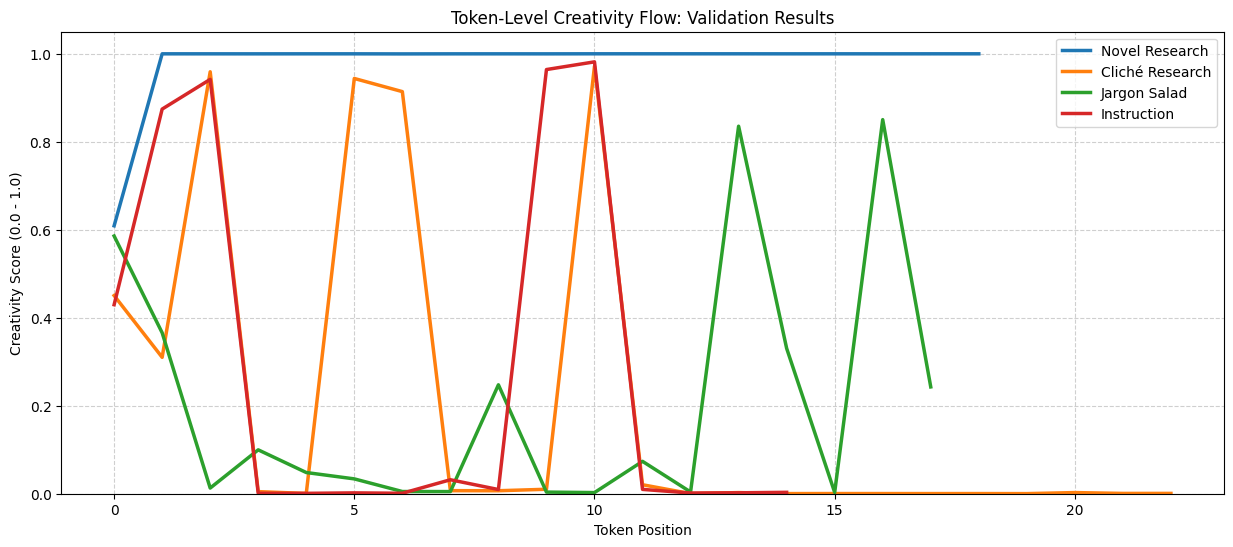

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
eval_token_level_probe.py

目的:
  トークンレベルProbeが「文脈」を理解しているか、それとも「単語」に反応しているだけかを
  ヒートマップと統計データで厳密に監査する。
"""

import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM

# ==========================================
# 1. 設定
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
PROBE_PATH = "transformer_creativity_probe_token_level.pt" # トークンレベルの方
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_LAYER = 24

# ==========================================
# 2. モデル定義 (Token-Level)
# ==========================================
class TransformerProbe(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=4):
        super().__init__()
        self.project = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.head = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.project(x)
        x = self.transformer(x)
        return self.head(x) # [Batch, Seq, 1]

# ==========================================
# 3. ロード処理
# ==========================================
print(f"Loading Base Model ({MODEL_NAME})...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map="auto"
)
base_model.eval()

print(f"Loading Token-Level Probe ({PROBE_PATH})...")
try:
    checkpoint = torch.load(PROBE_PATH, map_location=DEVICE)
    config = checkpoint["config"]
    
    probe = TransformerProbe(
        input_dim=config["input_dim"],
        d_model=config["d_model"],
        nhead=config["nhead"]
    ).to(DEVICE)
    
    probe.load_state_dict(checkpoint["model_state_dict"])
    probe.eval()
    print("✅ Probe Loaded Successfully!")
except Exception as e:
    print(f"❌ Failed to load: {e}")
    exit()

# ==========================================
# 4. 可視化・分析関数
# ==========================================
def analyze_sentence(text, category):
    """
    文章を入力し、トークンごとのスコアを計算・可視化する
    """
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = base_model(**inputs, output_hidden_states=True)
        h = out.hidden_states[TARGET_LAYER].float()
        
        # Probe Inference [1, Seq, 1]
        logits = probe(h)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy() # [Seq]
    
    # トークンIDを文字列に戻す
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    
    # DataFrame化
    df = pd.DataFrame({
        "Token": tokens,
        "Score": probs,
        "Position": range(len(tokens))
    })
    
    # 統計情報
    mean_score = df["Score"].mean()
    max_score = df["Score"].max()
    max_token = df.loc[df["Score"].idxmax()]["Token"]
    
    return df, mean_score, max_score, max_token

def plot_token_heatmap(df_list, title):
    """
    複数の文のトークンスコア推移をプロットする
    """
    plt.figure(figsize=(15, 6))
    
    for label, df in df_list:
        # トークンが見やすいように、先頭20-30トークンだけ表示したりする調整
        # ここでは全トークンをプロット
        sns.lineplot(data=df, x="Position", y="Score", label=label, linewidth=2.5)
        
    plt.title(f"Token-Level Creativity Flow: {title}")
    plt.ylabel("Creativity Score (0.0 - 1.0)")
    plt.xlabel("Token Position")
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# ==========================================
# 5. 実行 & 監査
# ==========================================
print("\n=== 🕵️‍♀️ Running Strict Token Audit ===")

test_cases = [
    # 1. 成功例であってほしい (Novel Research)
    ("Novel Research", 
     "We propose a novel framework that combines reinforcement learning with biological evolution to optimize neural architectures autonomously."),
    
    # 2. 低評価であってほしい (Cliché Research)
    ("Cliché Research", 
     "In this paper, we use a convolutional neural network to classify images from the MNIST dataset with high accuracy."),
    
    # 3. 専門用語サラダ (Jargon Salad) - これが重要！
    ("Jargon Salad", 
     "The quantum entropy leverages the blockchain synergy to disrupt the neural paradigm within the stochastic tensors."),
     
    # 4. 指示文/定型文 (Instruction)
    ("Instruction", 
     "Here is the list of research ideas you requested based on the parameters provided.")
]

results_summary = []
dfs_to_plot = []

for label, text in test_cases:
    print(f"\nProcessing: [{label}]")
    df, mean, peak, peak_tok = analyze_sentence(text, label)
    
    # 重要なトークンを表示 (Top 5)
    top_tokens = df.nlargest(5, "Score")
    top_str = ", ".join([f"{row['Token']}({row['Score']:.2f})" for _, row in top_tokens.iterrows()])
    
    print(f"  -> Mean Score: {mean:.4f}")
    print(f"  -> Peak Score: {peak:.4f} (at '{peak_tok}')")
    print(f"  -> Top Tokens: {top_str}")
    
    results_summary.append({
        "Category": label,
        "Mean": mean,
        "Peak": peak
    })
    dfs_to_plot.append((label, df))

# ==========================================
# 6. 判定ロジック (Pass/Fail)
# ==========================================
print("\n=== 📝 Final Strict Verdict ===")
df_res = pd.DataFrame(results_summary).set_index("Category")
print(df_res)

# 基準値の取得
novel_mean = df_res.loc["Novel Research", "Mean"]
salad_mean = df_res.loc["Jargon Salad", "Mean"]
cliche_mean = df_res.loc["Cliché Research", "Mean"]
instr_mean = df_res.loc["Instruction", "Mean"]

# 判定
# 1. Novelが一番高いこと
cond1 = novel_mean > cliche_mean and novel_mean > salad_mean
# 2. Salad（専門用語の羅列）が低く抑えられていること（少なくともNovelより大幅に低い）
cond2 = salad_mean < (novel_mean * 0.8) 
# 3. Instructionが低いこと
cond3 = instr_mean < 0.3

if cond1 and cond2 and cond3:
    print("\n✅ PASS: The probe correctly identifies context-aware creativity.")
    plot_token_heatmap(dfs_to_plot, "Validation Results")
else:
    print("\n⚠️ WARNING / FAIL:")
    if not cond1: print(f"  - Novel score is not the highest. (Novel: {novel_mean:.2f})")
    if not cond2: print(f"  - Probe is fooled by Jargon Salad. (Salad: {salad_mean:.2f})")
    if not cond3: print(f"  - Probe reacts to Instructions. (Instr: {instr_mean:.2f})")
    
    print("  -> Creating Plot for diagnosis...")
    plot_token_heatmap(dfs_to_plot, "Failed Validation Analysis")

Loading Base Model (Qwen/Qwen2.5-7B-Instruct)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading Token-Level Probe from transformer_creativity_probe_token_level.pt...
✅ Probe Loaded Successfully!

=== 🧪 Running Token-Level Verification ===
Domain     | Type       | Score    | Text Snippet
-----------------------------------------------------------------
Startup    | Cliché     |  -2.4346 | A to-do list app that helps yo...
Startup    | Novel      |   7.1782 | A social network that only all...
Research   | Cliché     |   5.8115 | Using deep learning to classif...
Research   | Novel      |   8.1747 | Training LLMs using simulated ...
Research   | Nonsense   |  -3.1821 | The quantum entropy leverages ...


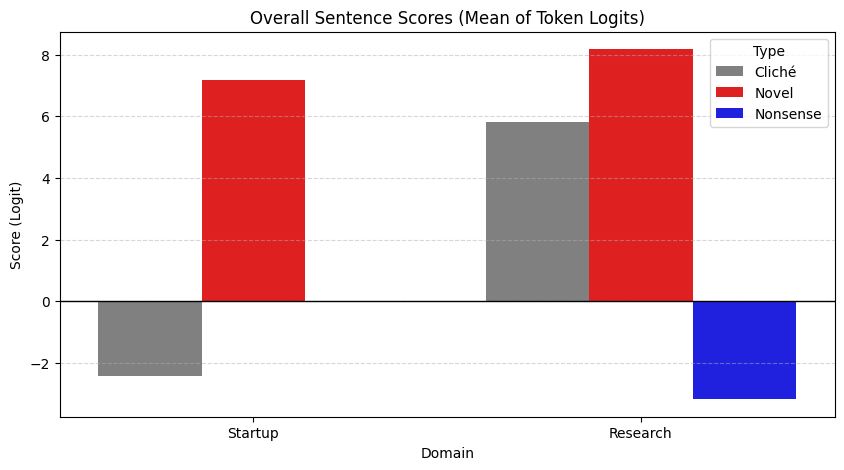

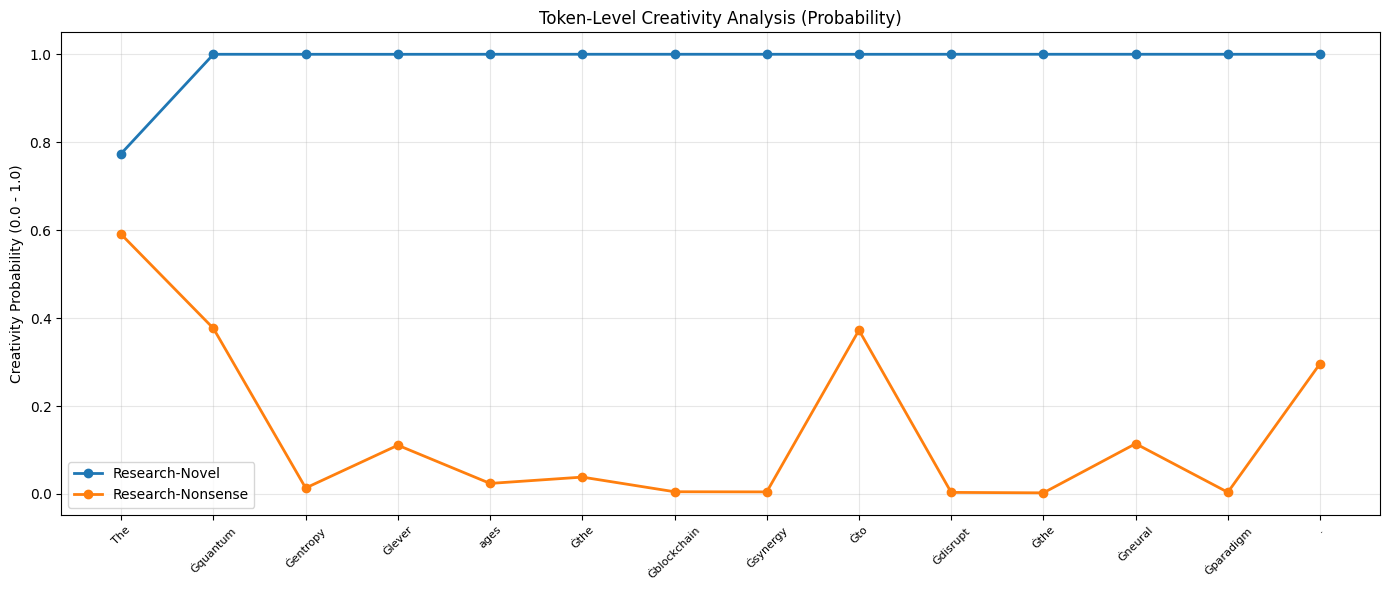


=== 📝 Final Verdict ===
Research Novel:    8.17
Research Nonsense: -3.18
Research Cliché:   5.81
✅ PASS: Token-Level Probe correctly identifies true novelty!
   (Jargon Salad is lower than Novel ideas)


In [5]:
# =================================================================
# verify_token_level_probe.py
# 目的: Token-Level Probe (.pt) をロードし、
#       1. 全体的な傾向（Bar Chart）
#       2. トークンごとの反応（Heatmap）
#       の両方を確認する。
# =================================================================

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np

# ==========================================
# 1. 設定 & モデル定義 (Token-Level仕様)
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
PROBE_PATH = "transformer_creativity_probe_token_level.pt" # Token-Levelのパス
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class TransformerProbe(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=4):
        super().__init__()
        self.project = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.head = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # x: [Batch, Seq, Input_Dim]
        x = self.project(x)
        x = self.transformer(x)
        # ★重要: mean(dim=1) しない！ [Batch, Seq, 1] を返す
        return self.head(x)

# ==========================================
# 2. ロード処理
# ==========================================
print(f"Loading Base Model ({MODEL_NAME})...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map="auto"
)
base_model.eval()

print(f"Loading Token-Level Probe from {PROBE_PATH}...")
try:
    checkpoint = torch.load(PROBE_PATH, map_location=DEVICE)
    config = checkpoint["config"]
    
    # Sequence-Levelのモデルを間違えてロードしないようにチェック
    if not config.get("token_level", False):
        print("⚠️ Warning: This seems to be a Sequence-Level probe. The architecture might mismatch.")

    probe = TransformerProbe(
        input_dim=config["input_dim"],
        d_model=config["d_model"],
        nhead=config["nhead"]
    ).to(DEVICE)
    
    probe.load_state_dict(checkpoint["model_state_dict"])
    probe.eval()
    
    TARGET_LAYER = config["layer_idx"]
    print(f"✅ Probe Loaded Successfully!")
    
except Exception as e:
    print(f"❌ Error loading probe: {e}")
    exit()

# ==========================================
# 3. 評価関数 (トークン単位 -> 平均化)
# ==========================================
def analyze_text(text):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = base_model(**inputs, output_hidden_states=True)
        h = out.hidden_states[TARGET_LAYER].float() # [1, Seq, Dim]
        
        # Probe Inference [1, Seq, 1]
        logits = probe(h)
        probs = torch.sigmoid(logits)
        
    # 全トークンの平均スコア（Logit）を「文章のスコア」とする
    # PPOの報酬計算と同じロジック
    avg_logit = logits.mean().item()
    
    # 可視化用にトークンごとのスコアも取得
    token_ids = inputs.input_ids[0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    token_scores = probs.squeeze().cpu().numpy()
    
    return avg_logit, tokens, token_scores

# ==========================================
# 4. ベンチマーク実行
# ==========================================
print("\n=== 🧪 Running Token-Level Verification ===")

benchmarks = [
    # --- Startup ---
    ("Startup", "Cliché", "A to-do list app that helps you organize tasks."),
    ("Startup", "Novel", "A social network that only allows posting once a year to encourage thoughtful content."),
    
    # --- Research (最重要) ---
    ("Research", "Cliché", "Using deep learning to classify images of cats and dogs."),
    ("Research", "Novel", "Training LLMs using simulated debates between historical figures to improve reasoning."),
    ("Research", "Nonsense", "The quantum entropy leverages the blockchain synergy to disrupt the neural paradigm."), # Jargon Salad
]

results = []
details = []

print(f"{'Domain':10s} | {'Type':10s} | {'Score':8s} | Text Snippet")
print("-" * 65)

for domain, type_, text in benchmarks:
    avg_logit, tokens, scores = analyze_text(text)
    
    results.append({
        "Domain": domain,
        "Type": type_,
        "Score (Logit)": avg_logit
    })
    
    details.append({
        "Label": f"{domain}-{type_}",
        "Tokens": tokens,
        "Scores": scores
    })
    
    print(f"{domain:10s} | {type_:10s} | {avg_logit:8.4f} | {text[:30]}...")

# ==========================================
# 5. 可視化 (Bar Chart & Heatmap)
# ==========================================

# --- A. 全体スコア比較 (Bar Chart) ---
df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Domain", y="Score (Logit)", hue="Type", 
            palette={"Cliché": "gray", "Novel": "red", "Nonsense": "blue"})
plt.axhline(0, color="black", linewidth=1.0)
plt.title(f"Overall Sentence Scores (Mean of Token Logits)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- B. トークンごとの反応 (Line Plot) ---
# Jargon Salad vs Novel Research の比較が見たい
plt.figure(figsize=(14, 6))

target_labels = ["Research-Novel", "Research-Nonsense"]
for item in details:
    if item["Label"] in target_labels:
        # 見やすいように先頭30トークンくらいを表示
        limit = min(len(item["Tokens"]), 40)
        x = range(limit)
        y = item["Scores"][:limit]
        
        plt.plot(x, y, marker='o', label=item["Label"], linewidth=2)
        
        # 単語をX軸に表示
        plt.xticks(x, item["Tokens"][:limit], rotation=45, fontsize=8)

plt.title("Token-Level Creativity Analysis (Probability)")
plt.ylabel("Creativity Probability (0.0 - 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================
# 6. 自動判定
# ==========================================
print("\n=== 📝 Final Verdict ===")
research_novel = df[(df["Domain"]=="Research") & (df["Type"]=="Novel")]["Score (Logit)"].values[0]
research_nonsense = df[(df["Domain"]=="Research") & (df["Type"]=="Nonsense")]["Score (Logit)"].values[0]
research_cliche = df[(df["Domain"]=="Research") & (df["Type"]=="Cliché")]["Score (Logit)"].values[0]

print(f"Research Novel:    {research_novel:.2f}")
print(f"Research Nonsense: {research_nonsense:.2f}")
print(f"Research Cliché:   {research_cliche:.2f}")

if research_novel > research_nonsense and research_novel > research_cliche:
    print("✅ PASS: Token-Level Probe correctly identifies true novelty!")
    print("   (Jargon Salad is lower than Novel ideas)")
elif research_novel > research_cliche:
    print("⚠️ WARNING: Novel > Cliché, but Nonsense is high.")
    print("   Check the line plot. Does nonsense spike at specific words?")
else:
    print("❌ FAIL: Probe prefers Cliché or Nonsense.")